In [1]:
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import sparse

import pickle

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [2]:
from recommender import plot_cm, IO, BaselineMean, BaselineRegression, ALS1, ALS2

In [3]:
%%time
# Load data

fig_dir = 'figs/modeling/Full/'

data_dir = 'data/Full/'
dfb = pd.read_pickle(data_dir + 'business.pkl')
dfr = pd.read_pickle(data_dir + 'review.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')
datar = pd.read_pickle(data_dir + 'data_review.pkl')

Wall time: 8.06 s


In [4]:
print(dfb.shape)
print(dfu.shape)
print(datar.shape)
datar.head()

(131025, 93)
(1117891, 22)
(4166778, 3)


,user_id,business_id,stars
0,0,0,2
1,1,0,2
2,2,0,2
3,3,0,3
4,4,0,2


In [5]:
%%time
# Split the dataset into a training set a test set

X_train, X_test, y_train, y_test = train_test_split(datar[['user_id', 'business_id']].values, datar['stars'].values, \
                                                   test_size=0.5, random_state=0)

Wall time: 388 ms


Baseline model 1 (estimating biases with sample averages):
Fitting time: 3.5102005004882812 s.
RMSE on training set: 1.0068002696892833.
RMSE on test set: 1.4186300607267675.
Baseline model 1 (estimating biases with sample averages):
Classification accuracy on training set: 0.5465397964566386.
Classification accuracy on test set: 0.36443362233361126.
Wall time: 1min 27s


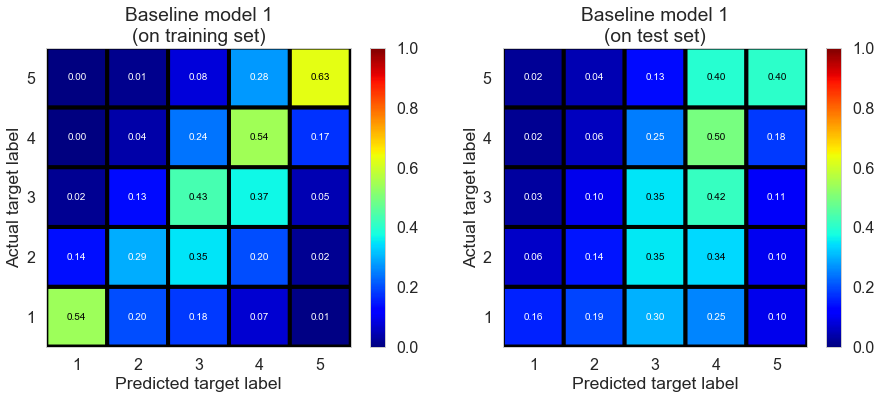

In [6]:
%%time
bm = BaselineMean().fit(X_train, y_train)

IO(data_dir + 'results/bm.pkl').to_pickle(bm)

model_name = 'Baseline model 1 (estimating biases with sample averages)'
print(model_name + ':')
print('Fitting time: {} s.'.format(bm.time_fitting[-1]))
print('RMSE on training set: {}.'.format(bm.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(bm.score(X_test, y_test, scoring='rmse')))

print(model_name + ':')
print('Classification accuracy on training set: {}.'.format(bm.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm.score(X_test, y_test, classification=True)))

y_pred_train_label = bm.predict(X_train, classification=True)
y_pred_test_label = bm.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 1\n(on training set)')
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 1\n(on test set)')

plt.savefig(fig_dir + 'bm1_cm.png', bbox_inches='tight')

In [7]:
%%time
alphas = [10**(i-5) for i in range(8)]
gs1 = GridSearchCV(BaselineRegression(classification=False), param_grid={'alpha':alphas}, scoring='neg_mean_squared_error', \
                  cv=5, return_train_score=True).fit(X_train, y_train)

IO(data_dir + 'results/gs1.pkl').to_pickle(gs1)

Wall time: 20min 7s


The best alpha (for regression question) determined through cross-validation is 1.


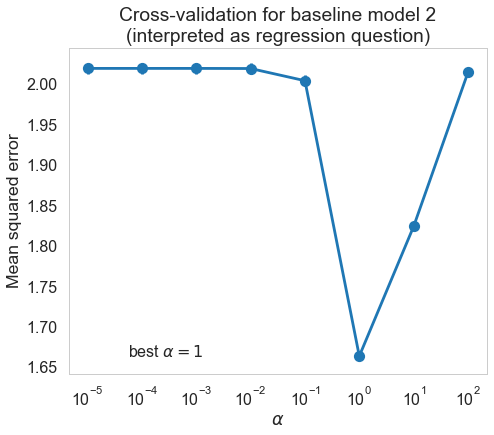

In [8]:
best_alpha1 = alphas[np.argmax(gs1.cv_results_['mean_test_score'])]
print('The best alpha (for regression question) determined through cross-validation is {}.'.format(best_alpha1))

plt.figure(figsize=(7.5, 6))
plt.errorbar(alphas, -gs1.cv_results_['mean_test_score'], gs1.cv_results_['std_test_score'], fmt='o-');
plt.semilogx(alphas, -gs1.cv_results_['mean_test_score'], alpha=0, label=r'best $\alpha = {}$'.format(best_alpha1));
plt.xlabel(r'$\alpha$');
plt.ylabel('Mean squared error');
plt.legend();
plt.title('Cross-validation for baseline model 2\n(interpreted as regression question)');

Baseline model 2 (estimating biases using regularized regression):
(alpha = 1)
Fitting time: 27.18555498123169 s.
RMSE on training set: 0.9198063584396539.
RMSE on test set: 1.282424983210685.

Classification accuracy on training set: 0.4448175544749444.
Classification accuracy on test set: 0.3263711193636906.
Wall time: 52.2 s


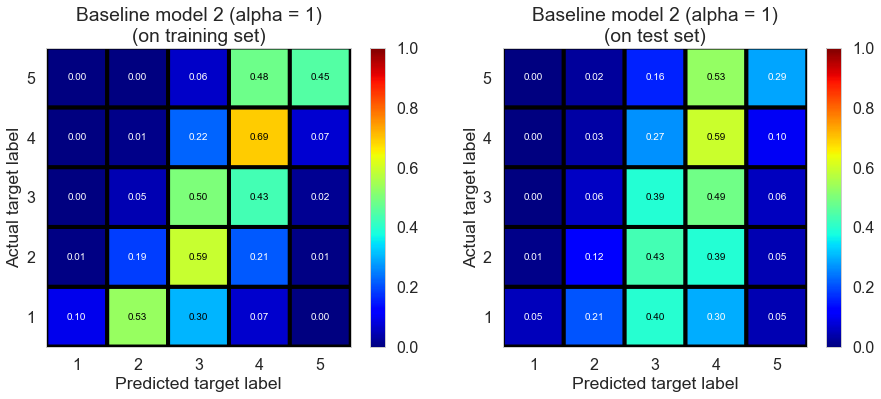

In [ ]:
%%time

alpha = best_alpha1

bm2 = BaselineRegression(alpha=alpha).fit(X_train, y_train)

IO(data_dir + 'results/bm2.pkl').to_pickle(bm2)

print('Baseline model 2 (estimating biases using regularized regression):')
print('(alpha = {})'.format(alpha))
print('Fitting time: {} s.'.format(bm2.time_fitting[-1]))
print('RMSE on training set: {}.'.format(bm2.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(bm2.score(X_test, y_test, scoring='rmse')))
print()
print('Classification accuracy on training set: {}.'.format(bm2.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm2.score(X_test, y_test, classification=True)))

y_pred_train_label = bm2.predict(X_train, classification=True)
y_pred_test_label = bm2.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 2 (alpha = {})\n(on training set)'.\
        format(alpha))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 2 (alpha = {})\n(on test set)'.\
        format(alpha))

plt.savefig(fig_dir + 'bm2_cm_alpha1.png', bbox_inches='tight')

In [ ]:
%%time
alpha = best_alpha1
iterations = 10
rank = 100

als2 = ALS2(alpha=alpha, iterations=iterations, rank=rank).fit(X_train, y_train)

IO(data_dir + 'results/als2.pkl').to_pickle(als2)

In [ ]:
print('ALS:')
print('(alpha = {}, iterations = {}, rank = {})'.format(alpha, iterations, rank))
print('Fitting time: {} s.'.format(als2.time_fitting[-1]))
print('RMSE on training set: {}.'.format(als2.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(als2.score(X_test, y_test, scoring='rmse')))
print()
print('Classification accuracy on training set: {}.'.format(als2.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(als2.score(X_test, y_test, classification=True)))

y_pred_train_label = als2.predict(X_train, classification=True)
y_pred_test_label = als2.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'ALS (alpha = {}, iterations = {}, rank = {})\n(on training set)'.\
        format(alpha, iterations, rank))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'ALS (alpha = {}, iterations = {}, rank = {})\n(on test set)'.\
        format(alpha, iterations, rank))

plt.savefig(fig_dir + 'als2_cm1.png', bbox_inches='tight')